In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy
import cartopy.util as util
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # features such as the ocean, coastlines rivers, etc
import cmocean
import pop_tools 

### Creating a coastal mask

In [ ]:
cesm_sst_data = xr.open_mfdataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/day_1/'+ 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.nday1.SST.*' + '.nc')

SST = cesm_sst_data['SST']
SST = SST[0,:,:] 

# Create a coastal mask filled with zeros
nlat=384
nlon=320
coastal_mask = np.zeros((nlat, nlon))

#Looping through each grid cell to get coastal cells

for i in range(1, nlat-1):
    for j in range(1, nlon-1):
        if not np.isnan(SST[i, j]): #I need ti first ensure that the current cell is in the ocean then I can get the neighbouring cells which are land (nan)
            if (np.isnan(SST[i+1, j]) or np.isnan(SST[i-1, j]) or  
               np.isnan(SST[i, j+1]) or np.isnan(SST[i, j-1])):
               coastal_mask[i, j] = 1


lat = cesm_sst_data['TLAT']
lon = cesm_sst_data['TLONG']

np.shape(coastal_mask)

p = plt.contourf(coastal_mask)
plt.colorbar(p)

import netCDF4 as nc

filePath = '/glade/u/home/kasante/Final_Mangrove_model/'
fileName = filePath + 'coastal_cells_mask.nc'
dataSet = nc.Dataset(fileName, 'w', format='NETCDF4')

nlat = dataSet.createDimension('nlat', 384)
nlon = dataSet.createDimension('nlon',320)

var_name = 'coastal_mask'
coastal_mask_file = dataSet.createVariable(var_name, np.float32, ('nlat','nlon'))
coastal_mask_file.units = ''

TLONG = dataSet.createVariable('TLONG', np.float32, ('nlat','nlon'))#SST = ds.createVariable('SST', np.float32, ('SST',))
TLONG.units = 'degrees_east'
TLAT = dataSet.createVariable('TLAT', np.float32, ('nlat','nlon'))#SST = ds.createVariable('SST', np.float32, ('SST',))
TLAT.units = 'degrees_north'
coastal_mask_file[:,:] = coastal_mask

TLONG[:,:] = lon.values
TLAT[:,:] = lat.values
print(dataSet)

dataSet.close()

In [3]:
hist = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001/ocn/proc/tseries/day_1/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001.pop.h.nday1.SST.18500101-20141231.nc')
ssp = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/day_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.nday1.SST.20150101-20650101.nc')
ARISE = xr.open_dataset('/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h1.T.20550101-20641231.nc')
CM = xr.open_dataset('/glade/u/home/kasante/Final_Mangrove_model/coastal_cells_mask.nc')
mangrove_polygon_shp = gpd.read_file('/glade/u/home/kasante/GMW_data_mask/gmw_v3_tiles_shp.shp')

### For Historical

In [4]:
hist = hist['SST']
hist = hist.sel(time = slice('1850-01-01', '1859-12-31'))
Hist_min_temp = hist.min(dim="time")
Hist_min_temp

<xarray.DataArray 'SST' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.9172398, -1.9176242, -1.917512 , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

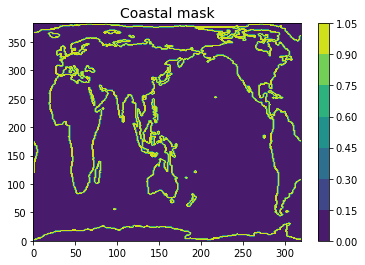

In [5]:
coastal_mask = CM['coastal_mask']
p = plt.contourf(coastal_mask)
plt.title('Coastal mask', fontsize = 14)
plt.colorbar(p);

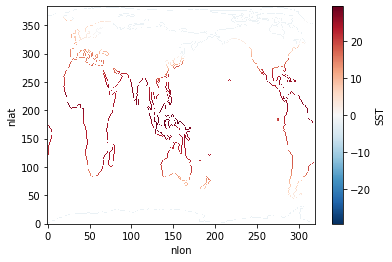

In [6]:
Hist_mask = Hist_min_temp.where(coastal_mask == 1)
Hist_mask.plot();

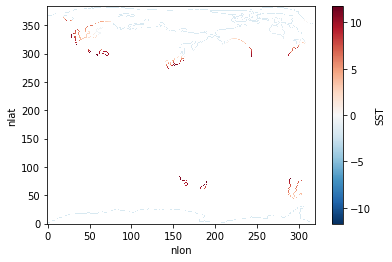

In [7]:
Hist_Temp = Hist_mask.where(Hist_mask.values <=  11.73)
Hist_Temp.plot();

In [8]:
def pop_add_cyclic(data,TLAT,TLONG): 
    nj = TLAT.shape[0] # size of POP grid
    ni = TLONG.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)
    tlon = TLONG
    tlat = TLAT
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
    if ni == 320: # this is the x1 POP grid
        lon[367:-3, 0] = lon[367:-3, 0] + 360.        
    lon = lon - 360.
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))
    lon_dim = 1 #ds[v].dims.index('nlon')
    field = data
    field = np.concatenate((field, field), 1)
    field = field[:, xL:xR]
    field = np.concatenate((field, field[:, 0:1]), lon_dim) 
    return field, lat, lon

In [9]:
data, tlat, tlong = pop_add_cyclic(Hist_Temp, Hist_Temp['TLAT'], Hist_Temp['TLONG'])

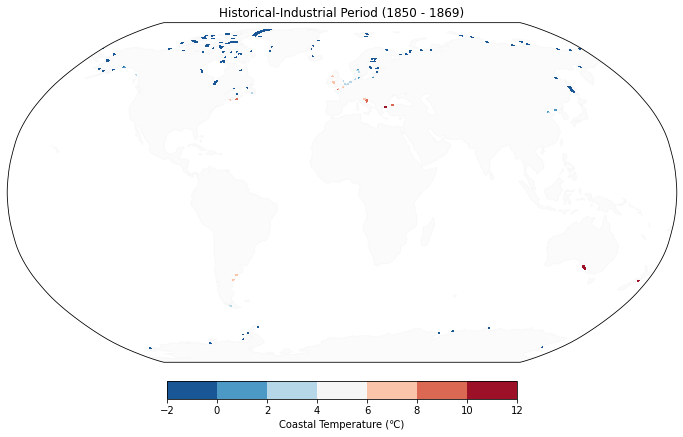

In [10]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.09, zorder=-1)
ax.set_global()
ax.set_title('Historical-Industrial Period (1850 - 1869)')
# Create the filled contour plot
contour = plt.contourf(tlong, tlat, data, transform=ccrs.PlateCarree(), zorder=1, cmap='RdBu_r')
# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Coastal Temperature (℃)')  # You can customize the label here
plt.show();

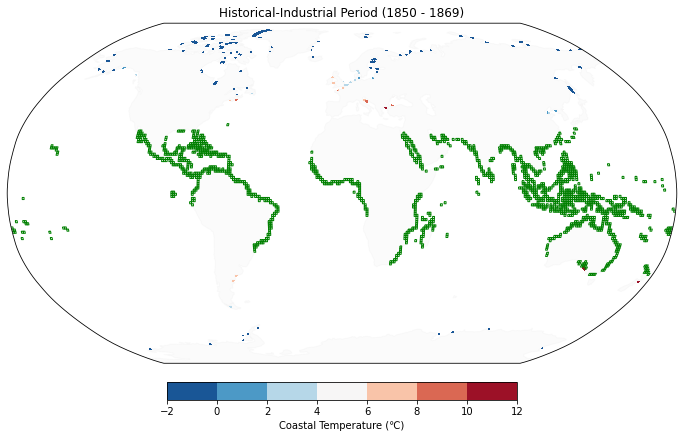

In [11]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.09, zorder=-1)
ax.set_global()
ax.set_title('Historical-Industrial Period (1850 - 1869)')
# Create the filled contour plot
contour = plt.contourf(tlong, tlat, data, transform=ccrs.PlateCarree(), zorder=1, cmap='RdBu_r')

# Add the mangrove polygon shapefile boundary
mangrove_polygon_shp.boundary.plot(ax=ax, linewidth=1, color='green', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Coastal Temperature (℃)')  # You can customize the label here
plt.show();

In [12]:
Hist_Temp.min()

<xarray.DataArray 'SST' ()>
array(-1.95112932)

In [13]:
Hist_Temp.max()

<xarray.DataArray 'SST' ()>
array(11.7139883)

In [14]:
Hist_Temp.std()

<xarray.DataArray 'SST' ()>
array(3.67105889)

### For ARISE SAI

I changed directory for each ensemble file beginning with member 1 through till 4, for both SAI and SSP simulations

In [94]:
ARISE = xr.open_dataset('/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h1.T.20550101-20641231.nc')

In [95]:
SAI = ARISE['T'][:,-1,:,:]

In [96]:
SAI = SAI - 273.15
SAI

<xarray.DataArray 'T' (time: 3650, lat: 192, lon: 288)>
array([[[-22.557846, -22.557846, -22.557846, ..., -22.557846,
         -22.557846, -22.557846],
        [-21.905869, -21.865189, -21.822357, ..., -22.040985,
         -21.993027, -21.94896 ],
        [-21.397217, -21.33046 , -21.28157 , ..., -21.64241 ,
         -21.55426 , -21.465057],
        ...,
        [-32.37671 , -32.38527 , -32.391342, ..., -32.3356  ,
         -32.35002 , -32.36519 ],
        [-32.194016, -32.199326, -32.20468 , ..., -32.17549 ,
         -32.182236, -32.18831 ],
        [-28.016266, -28.01651 , -28.016724, ..., -28.015396,
         -28.015717, -28.016006]],

       [[-22.641846, -22.641846, -22.641846, ..., -22.641846,
         -22.641846, -22.641846],
        [-22.457703, -22.470367, -22.48854 , ..., -22.391068,
         -22.41217 , -22.440903],
        [-22.27858 , -22.327042, -22.376343, ..., -22.13768 ,
         -22.184128, -22.23111 ],
...
        [-15.795593, -15.857697, -15.921722, ..., -15.627228,
         -15.680939, -15.736908],
        [-18.806915, -18.837418, -18.871445, ..., -18.730057,
         -18.75438 , -18.779434],
        [-21.273285, -21.272812, -21.272385, ..., -21.27504 ,
         -21.274399, -21.273819]],

       [[-23.675583, -23.675583, -23.675583, ..., -23.675583,
         -23.675583, -23.675583],
        [-26.50673 , -26.56749 , -26.61522 , ..., -26.284027,
         -26.365158, -26.44017 ],
        [-28.217514, -28.326447, -28.447098, ..., -27.935684,
         -28.025589, -28.12091 ],
        ...,
        [-14.889374, -14.934692, -14.982391, ..., -14.77301 ,
         -14.809418, -14.848877],
        [-16.998016, -17.019379, -17.043762, ..., -16.937256,
         -16.956024, -16.976196],
        [-20.243027, -20.243042, -20.243073, ..., -20.24295 ,
         -20.242981, -20.242996]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev      float64 992.6
  * time     (time) object 2055-01-01 00:00:00 ... 2064-12-31 00:00:00

In [97]:
SAI = SAI.rename({'lat' : 'nlat'})
SAI = SAI.rename({'lon' : 'nlon'})

target_lat = hist.ULAT.values
target_lon = hist.ULONG.values
target_TLAT = hist.TLAT.values
target_TLONG = hist.TLONG.values

# Interpolate `SAI_2` onto the target grid (based on ULAT and ULONG)
SAI_1 = SAI.interp(
    nlat=xr.DataArray(target_lat[:, 0], dims="nlat"),  # Latitude values
    nlon=xr.DataArray(target_lon[0, :], dims="nlon"),  # Longitude values
    method="linear"  # Interpolation method
)

# Add TLAT and TLONG as coordinates to the resampled DataArray
SAI_1 = SAI_1.assign_coords(
    TLAT=(("nlat", "nlon"), target_TLAT),
    TLONG=(("nlat", "nlon"), target_TLONG)
)

In [98]:
SAI_1

<xarray.DataArray 'T' (time: 3650, nlat: 384, nlon: 320)>
array([[[ -2.71132832,  -2.53258479,  -2.40808161, ...,  -3.31015378,
          -3.15739362,  -2.98776916],
        [ -2.96135084,  -2.9036993 ,  -2.78280452, ...,  -3.02446884,
          -3.0177765 ,  -3.02901763],
        [ -3.07070679,  -3.20897051,  -3.12799758, ...,  -2.54501267,
          -2.65562385,  -2.84332124],
        ...,
        [-33.185302  , -33.36070621, -33.32494111, ..., -31.96095552,
         -32.44663698, -32.924538  ],
        [-33.82314352, -33.95358885, -33.88930151, ..., -32.81486887,
         -33.24408094, -33.64181868],
        [-34.4439301 , -34.53901614, -34.45134058, ..., -33.52014084,
         -33.94068359, -34.27716724]],

       [[ -2.27522017,  -2.35289343,  -2.54245065, ...,  -3.15011181,
          -2.75407728,  -2.39265502],
        [ -2.18647121,  -2.36068264,  -2.60273731, ...,  -2.74843768,
          -2.46893836,  -2.21555767],
        [ -1.90095173,  -2.11421604,  -2.50204379, ...,  -2.18544638,
          -2.00285344,  -1.8629313 ],
...
        [-31.56336872, -31.32664029, -30.81270054, ..., -31.35921968,
         -31.56024518, -31.59776936],
        [-31.93733614, -31.64279158, -31.07253418, ..., -31.50895281,
         -31.84500227, -32.01016141],
        [-32.03270929, -31.76899772, -31.24642621, ..., -31.53141539,
         -31.91087934, -32.10250638]],

       [[ -6.08117757,  -5.9588456 ,  -5.80459187, ...,  -6.23928206,
          -6.12451566,  -6.03379522],
        [ -5.09595592,  -5.04501899,  -5.03004669, ...,  -5.28482439,
          -5.16089226,  -5.0512394 ],
        [ -3.5150282 ,  -3.82681147,  -4.25976398, ...,  -3.44962497,
          -3.35824695,  -3.3495037 ],
        ...,
        [-34.33500468, -34.03237338, -33.5482263 , ..., -33.59369891,
         -34.11046844, -34.41197599],
        [-34.21087781, -33.92264194, -33.53231228, ..., -33.83087517,
         -34.21471578, -34.3314079 ],
        [-34.3734587 , -34.09804577, -33.76623368, ..., -34.06205964,
         -34.40700681, -34.48572246]]])
Coordinates:
    lev      float64 992.6
  * time     (time) object 2055-01-01 00:00:00 ... 2064-12-31 00:00:00
  * nlat     (nlat) float64 -78.95 -78.42 -77.88 -77.35 ... 71.51 71.96 72.41
  * nlon     (nlon) float64 321.1 322.3 323.4 324.5 ... 316.6 317.8 318.9 320.0
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8

In [99]:
SAI_min_temp = SAI_1.min(dim="time")
SAI_min_temp

<xarray.DataArray 'T' (nlat: 384, nlon: 320)>
array([[-57.30528452, -55.61547411, -53.15241495, ..., -59.5212844 ,
        -59.3705518 , -57.8656361 ],
       [-56.08827469, -54.45322919, -51.86763143, ..., -55.75252024,
        -55.43079286, -55.83637356],
       [-49.66464157, -48.24996863, -46.74559655, ..., -51.99119589,
        -50.62588881, -49.98891773],
       ...,
       [-49.51693326, -50.0286556 , -50.10865254, ..., -48.18504753,
        -48.79199799, -48.78937929],
       [-50.0481278 , -50.61244203, -50.67152613, ..., -48.90724705,
        -49.2751638 , -49.26006001],
       [-50.37124595, -50.94054828, -51.01368356, ..., -49.18961209,
        -49.33414916, -49.53164516]])
Coordinates:
    lev      float64 992.6
  * nlat     (nlat) float64 -78.95 -78.42 -77.88 -77.35 ... 71.51 71.96 72.41
  * nlon     (nlon) float64 321.1 322.3 323.4 324.5 ... 316.6 317.8 318.9 320.0
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8

In [100]:
SAI_mask = SAI_min_temp.where(coastal_mask == 1)

In [101]:
SAI_Temp = SAI_mask.where(SAI_mask.values <=  11.73)

In [102]:
data, tlat, tlong = pop_add_cyclic(SAI_Temp, SAI_Temp['TLAT'], SAI_Temp['TLONG'])

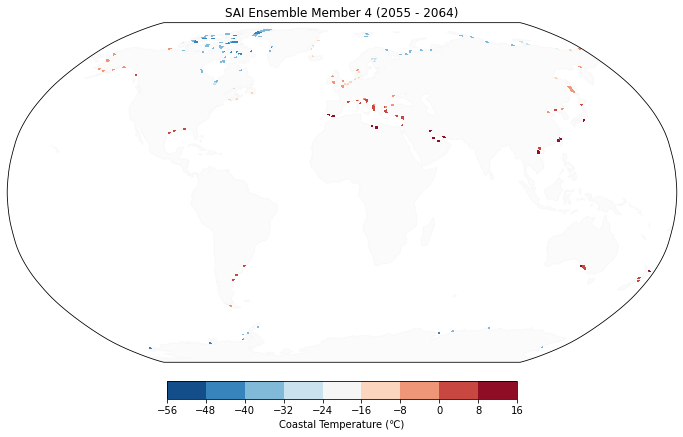

In [103]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.09, zorder=-1)
ax.set_global()
ax.set_title('SAI Ensemble Member 4 (2055 - 2064)')
# Create the filled contour plot
contour = plt.contourf(tlong, tlat, data, transform=ccrs.PlateCarree(), zorder=1, cmap='RdBu_r')
# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Coastal Temperature (℃)') 
plt.show();

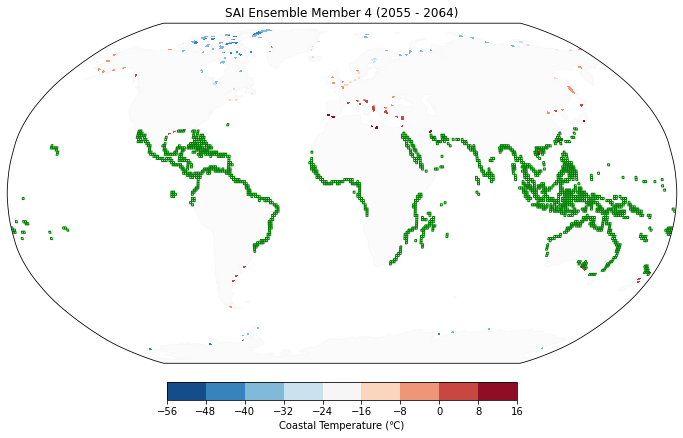

In [104]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.09, zorder=-1)
ax.set_global()
ax.set_title('SAI Ensemble Member 4 (2055 - 2064)')
# Create the filled contour plot
contour = plt.contourf(tlong, tlat, data, transform=ccrs.PlateCarree(), zorder=1, cmap='RdBu_r')

# Add the mangrove polygon shapefile boundary
mangrove_polygon_shp.boundary.plot(ax=ax, linewidth=1, color='green', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Coastal Temperature (℃)') 
plt.show();

In [105]:
SAI_Temp.min()

<xarray.DataArray 'T' ()>
array(-51.12579667)
Coordinates:
    lev      float64 992.6

In [106]:
SAI_Temp.max()

<xarray.DataArray 'T' ()>
array(11.70042017)
Coordinates:
    lev      float64 992.6

In [107]:
SAI_Temp.std()

<xarray.DataArray 'T' ()>
array(19.64110842)
Coordinates:
    lev      float64 992.6

### For SSP 2-4.5 Future

In [109]:
ssp = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.004/ocn/proc/tseries/day_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.004.pop.h.nday1.SST.20150101-20650101.nc')

In [110]:
ssp

<xarray.Dataset>
Dimensions:                 (z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, nlat: 384, nlon: 320, time: 18250,
                             d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * time                    (time) object 2015-01-02 00:00:00 ... 2065-01-01 ...
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/52)
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat, nlon) float64 ...
    KMU                     (nlat, nlon) float64 ...
    REGION_MASK             (nlat, nlon) float64 ...
    UAREA                   (nlat, nlon) float64 ...
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object ...
    SST                     (time, nlat, nlon) float32 ...
Attributes:
    title:             b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.004
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-12-22 at 08:52:30.4
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [111]:
ssp_1 = ssp['SST']
ssp_1 = ssp_1.sel(time = slice('2055-01-01', '2064-12-31'))
ssp_min_temp = ssp_1.min(dim="time")
ssp_min_temp

<xarray.DataArray 'SST' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.9059395, -1.9057474, -1.9056684, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

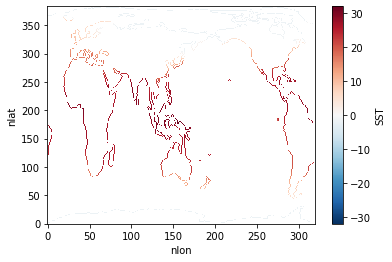

In [112]:
ssp_mask = ssp_min_temp.where(coastal_mask == 1)
ssp_mask.plot();

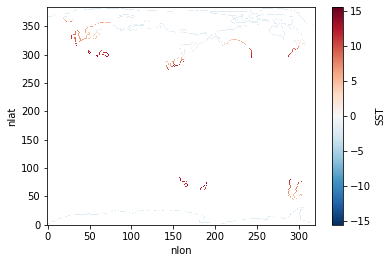

In [113]:
ssp_Temp = ssp_mask.where(Hist_mask.values <=  11.73)
ssp_Temp.plot();

In [114]:
data, tlat, tlong = pop_add_cyclic(ssp_Temp, ssp_Temp['TLAT'], ssp_Temp['TLONG'])

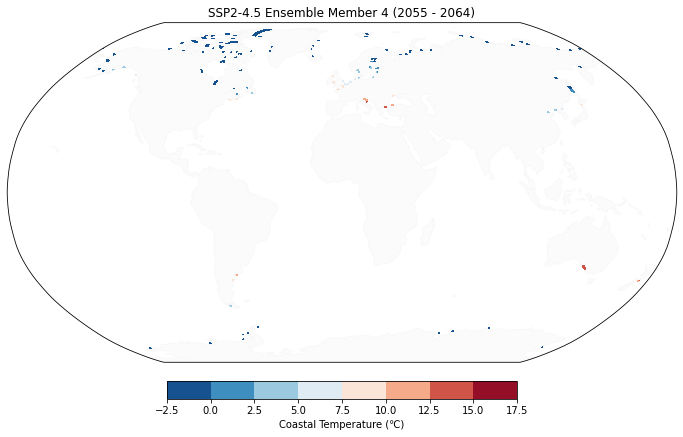

In [115]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.09, zorder=-1)
ax.set_global()
ax.set_title('SSP2-4.5 Ensemble Member 4 (2055 - 2064)')
# Create the filled contour plot
contour = plt.contourf(tlong, tlat, data, transform=ccrs.PlateCarree(), zorder=1, cmap='RdBu_r')
# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Coastal Temperature (℃)')  # You can customize the label here
plt.show();

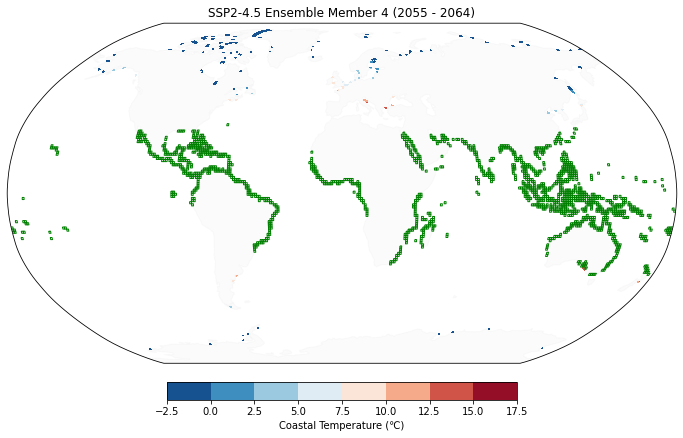

In [116]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.09, zorder=-1)
ax.set_global()
ax.set_title('SSP2-4.5 Ensemble Member 4 (2055 - 2064)')
# Create the filled contour plot
contour = plt.contourf(tlong, tlat, data, transform=ccrs.PlateCarree(), zorder=1, cmap='RdBu_r')

# Add the mangrove polygon shapefile boundary
mangrove_polygon_shp.boundary.plot(ax=ax, linewidth=1, color='green', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Coastal Temperature (℃)')  # You can customize the label here
plt.show();

In [117]:
ssp_Temp.min()

<xarray.DataArray 'SST' ()>
array(-1.94265032)

In [118]:
ssp_Temp.max()

<xarray.DataArray 'SST' ()>
array(15.52592278)

In [119]:
ssp_Temp.std()

<xarray.DataArray 'SST' ()>
array(4.3594265)

### Ensemble member mean across time

#### SAI file 

In [121]:
SM_1 = xr.open_dataset('/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h1.T.20550101-20641231.nc')
SM_2 = xr.open_dataset('/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002.cam.h1.T.20550101-20641231.nc')
SM_3 = xr.open_dataset('/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003.cam.h1.T.20550101-20641231.nc')
SM_4 = xr.open_dataset('/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.cam.h1.T.20550101-20641231.nc')

SM_1 = SM_1['T'][:,-1,:,:]
SM_2 = SM_2['T'][:,-1,:,:]
SM_3 = SM_3['T'][:,-1,:,:]
SM_4 = SM_4['T'][:,-1,:,:]

SM_1 = SM_1 - 273.15
SM_2 = SM_2 - 273.15
SM_3 = SM_3 - 273.15
SM_4 = SM_4 - 273.15

In [136]:
# Mask the datasets to include only values <= 11.73
masked_SM_1 = SM_1.where(SM_1 <= 11.73)
masked_SM_2 = SM_2.where(SM_2 <= 11.73)
masked_SM_3 = SM_3.where(SM_3 <= 11.73)
masked_SM_4 = SM_4.where(SM_4 <= 11.73)

In [137]:
# Calculate the mean minimum daily temperature across latitude and longitude within the range
MMT_SM_1 = masked_SM_1.mean(dim=["lat", "lon"]).sel(time=slice('2060-01-01', '2060-12-31'))
MMT_SM_2 = masked_SM_2.mean(dim=["lat", "lon"]).sel(time=slice('2060-01-01', '2060-12-31'))
MMT_SM_3 = masked_SM_3.mean(dim=["lat", "lon"]).sel(time=slice('2060-01-01', '2060-12-31'))
MMT_SM_4 = masked_SM_4.mean(dim=["lat", "lon"]).sel(time=slice('2060-01-01', '2060-12-31'))

In [132]:
SM_1_time = SM_1.sel(time = slice('2060-01-01', '2060-12-31'))
SM_2_time = SM_2.sel(time = slice('2060-01-01', '2060-12-31'))
SM_3_time = SM_3.sel(time = slice('2060-01-01', '2060-12-31'))
SM_4_time = SM_4.sel(time = slice('2060-01-01', '2060-12-31'))

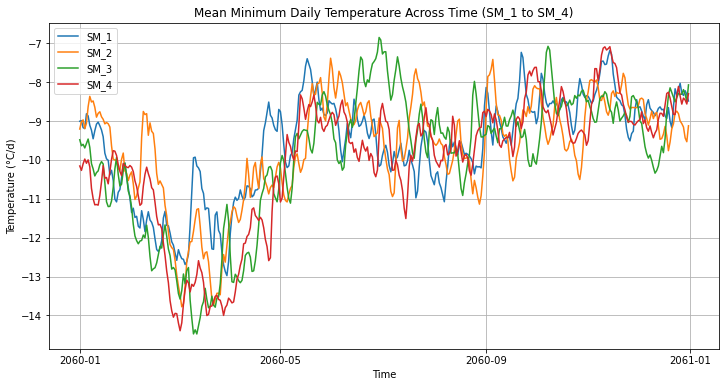

In [162]:


# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(SM_1_time.time, MMT_SM_1, label="SM_1")
plt.plot(SM_2_time.time, MMT_SM_2, label="SM_2")
plt.plot(SM_3_time.time, MMT_SM_3, label="SM_3")
plt.plot(SM_4_time.time, MMT_SM_4, label="SM_4")

plt.title("Mean Minimum Daily Temperature Across Time (SM_1 to SM_4)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C/d)")
plt.legend()
plt.grid()
plt.show()

In [139]:
SM_Mean = (MMT_SM_1 + MMT_SM_2 + MMT_SM_3 + MMT_SM_4)/4

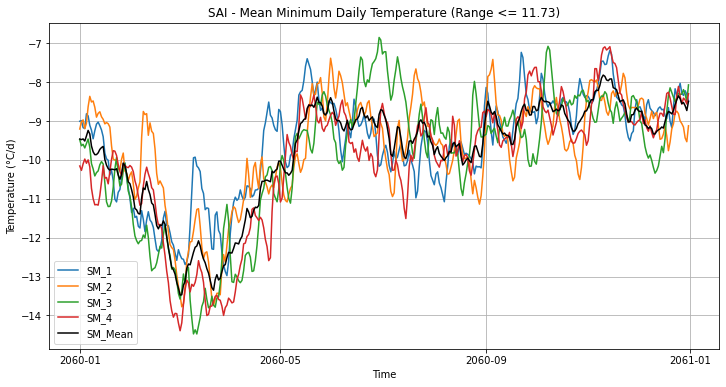

In [161]:

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(SM_1_time.time, MMT_SM_1, label="SM_1")
plt.plot(SM_2_time.time, MMT_SM_2, label="SM_2")
plt.plot(SM_3_time.time, MMT_SM_3, label="SM_3")
plt.plot(SM_4_time.time, MMT_SM_4, label="SM_4")
plt.plot(SM_4_time.time, SM_Mean, label="SM_Mean", color='black')

plt.title("SAI - Mean Minimum Daily Temperature (Range <= 11.73)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C/d)")
plt.legend()
plt.grid()
plt.show()

### SSP file

In [143]:
ssp_1 = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/day_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.nday1.SST.20150101-20650101.nc')
ssp_2 = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.002/ocn/proc/tseries/day_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.002.pop.h.nday1.SST.20150101-20650101.nc')
ssp_3 = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.003/ocn/proc/tseries/day_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.003.pop.h.nday1.SST.20150101-20650101.nc')
ssp_4 = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.004/ocn/proc/tseries/day_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.004.pop.h.nday1.SST.20150101-20650101.nc')

ssp_1 = ssp_1['SST']
ssp_2 = ssp_2['SST']
ssp_3 = ssp_3['SST']
ssp_4 = ssp_4['SST']

In [144]:
masked_ssp_1 = ssp_1.where(ssp_1 <= 11.73)
masked_ssp_2 = ssp_2.where(ssp_2 <= 11.73)
masked_ssp_3 = ssp_3.where(ssp_3 <= 11.73)
masked_ssp_4 = ssp_4.where(ssp_4 <= 11.73)

In [146]:
# Calculate the mean minimum daily temperature across latitude and longitude within the range
MMT_ssp_1 = masked_ssp_1.mean(dim=["nlat", "nlon"]).sel(time=slice('2060-01-01', '2060-12-31'))
MMT_ssp_2 = masked_ssp_2.mean(dim=["nlat", "nlon"]).sel(time=slice('2060-01-01', '2060-12-31'))
MMT_ssp_3 = masked_ssp_3.mean(dim=["nlat", "nlon"]).sel(time=slice('2060-01-01', '2060-12-31'))
MMT_ssp_4 = masked_ssp_4.mean(dim=["nlat", "nlon"]).sel(time=slice('2060-01-01', '2060-12-31'))

In [147]:
ssp_1_time = ssp_1.sel(time = slice('2060-01-01', '2060-12-31'))
ssp_2_time = ssp_2.sel(time = slice('2060-01-01', '2060-12-31'))
ssp_3_time = ssp_3.sel(time = slice('2060-01-01', '2060-12-31'))
ssp_4_time = ssp_4.sel(time = slice('2060-01-01', '2060-12-31'))

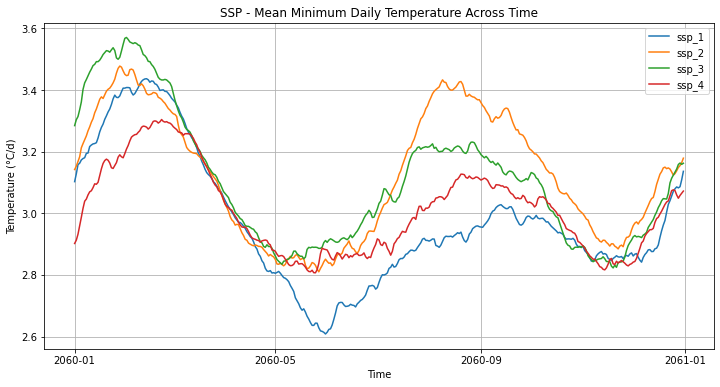

In [160]:

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(ssp_1_time.time, MMT_ssp_1, label="ssp_1")
plt.plot(ssp_2_time.time, MMT_ssp_2, label="ssp_2")
plt.plot(ssp_3_time.time, MMT_ssp_3, label="ssp_3")
plt.plot(ssp_4_time.time, MMT_ssp_4, label="ssp_4")

plt.title("SSP - Mean Minimum Daily Temperature Across Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C/d)")
plt.legend()
plt.grid()
plt.show()

In [149]:
ssp_Mean = (MMT_ssp_1 + MMT_ssp_2 + MMT_ssp_3 + MMT_ssp_4)/4

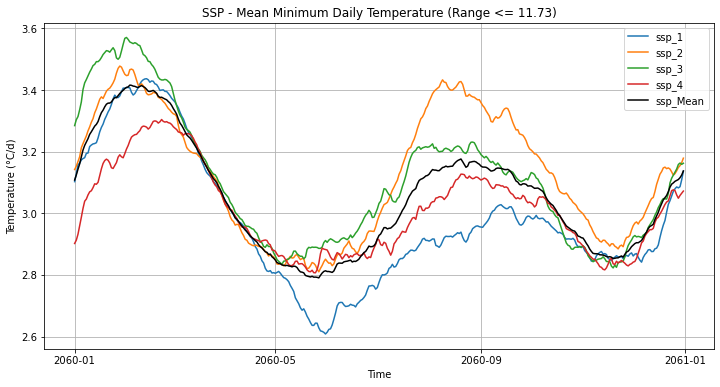

In [159]:
plt.figure(figsize=(12, 6))
plt.plot(ssp_1_time.time, MMT_ssp_1, label="ssp_1")
plt.plot(ssp_2_time.time, MMT_ssp_2, label="ssp_2")
plt.plot(ssp_3_time.time, MMT_ssp_3, label="ssp_3")
plt.plot(ssp_4_time.time, MMT_ssp_4, label="ssp_4")
plt.plot(ssp_4_time.time, ssp_Mean, label="ssp_Mean", color='black')

plt.title("SSP - Mean Minimum Daily Temperature (Range <= 11.73)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C/d)")
plt.legend()
plt.grid()
plt.show()

In [154]:
len(ssp_1)

18250

In [155]:
len(SM_1)

3650

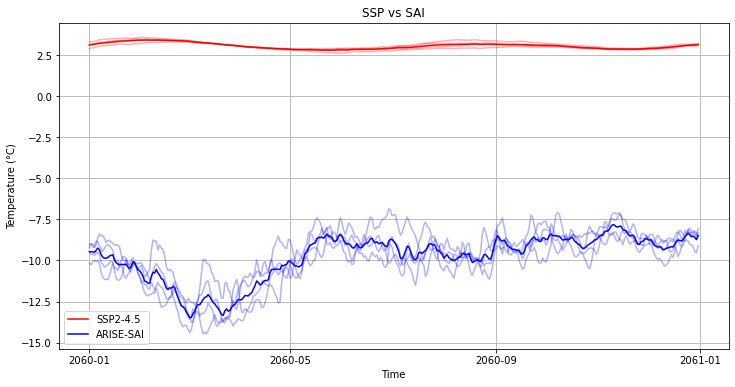

In [173]:
plt.figure(figsize=(12, 6))
plt.plot(ssp_1_time.time, MMT_ssp_1, color='red', alpha=0.3)
plt.plot(ssp_2_time.time, MMT_ssp_2, color='red', alpha=0.3)
plt.plot(ssp_3_time.time, MMT_ssp_3, color='red', alpha=0.3)
plt.plot(ssp_4_time.time, MMT_ssp_4, color='red', alpha=0.3)
plt.plot(ssp_4_time.time, ssp_Mean, label="SSP2-4.5", color='red')

plt.plot(SM_1_time.time, MMT_SM_1, color='blue', alpha=0.3)
plt.plot(SM_2_time.time, MMT_SM_2, color='blue', alpha=0.3)
plt.plot(SM_3_time.time, MMT_SM_3, color='blue', alpha=0.3)
plt.plot(SM_4_time.time, MMT_SM_4, color='blue', alpha=0.3)
plt.plot(SM_4_time.time, SM_Mean, label="ARISE-SAI", color='blue')


plt.title("SSP vs SAI")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()